In [1]:
from planck_lite_py import PlanckLitePy
import jaxcapse
import jax.numpy as np
import matplotlib.pyplot as plt
import camb
from functools import partial
from scipy.stats import uniform, norm
import pocomc as pc
import numpy as np
from getdist import plots, MCSamples
import pandas as pd
import FastMPCarviz as fmpc
from getdist.plots import GetDistPlotter
from tqdm import tqdm
import nfcof_arviz4_dense as na
import arviz as az
from scipy.optimize import minimize
from tqdm import tqdm
import math as m

Iter: 38it [1:33:14, 147.22s/it, beta=1, calls=51712, ESS=3957, logZ=-327, logP=-295, acc=0.761, steps=7, eff=1]       


Removed no burn in


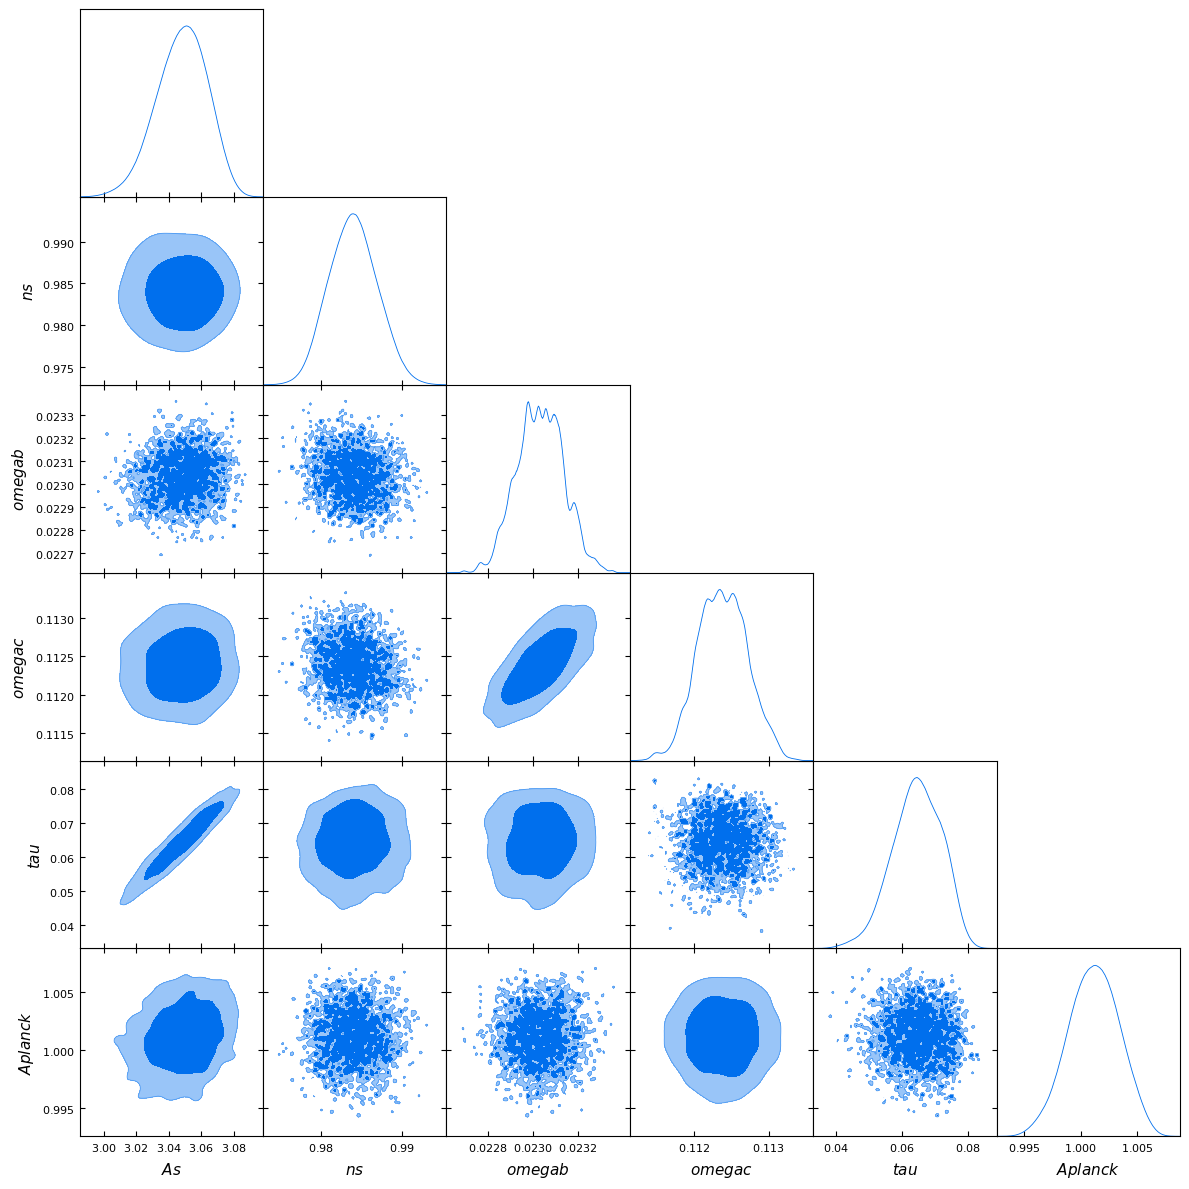

In [2]:
# -------------------------------- FID -------------------------------- #

#input_test = np.array([3.054, 0.9626, 67, 0.02233, 0.1207, 0.057, 1.00])
input_fid = np.array([3.054, 0.9626, 0.02233, 0.1207, 0.057, 1.00])
TT2018 = PlanckLitePy(data_directory='data', year=2018, spectra='TT', use_low_ell_bins=False)
plt.rcParams['text.usetex'] = False
Capse_TT = jaxcapse.load_emulator("../trained_emu/TT/")
Capse_EE = jaxcapse.load_emulator("../trained_emu/EE/")
Capse_TE = jaxcapse.load_emulator("../trained_emu/TE/")
Capse_PP = jaxcapse.load_emulator("../trained_emu/PP/")
lsTT = np.arange(2,2509)
lsTE = np.arange(2,1997)

def call_emu_planck_fid(input, Capse_TT, Capse_TE, Capse_EE):
    #cosmo_input = input[0:6]
    #Ap = input[6]
    As, ns, omegab, omegac, tau = input[0:5]
    Ap = input[5]

    cosmoinput = np.array([As, ns, 71, omegab, omegac, tau])

    
    Dl_TT = Capse_TT.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_TE = Capse_TE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_EE = Capse_EE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    return Dl_TT, Dl_TE, Dl_EE

def create_emu_planck_function_fid(Capse_TT, Capse_TE, Capse_EE):
    return partial(call_emu_planck_fid, Capse_TT=Capse_TT, Capse_TE=Capse_TE, Capse_EE=Capse_EE)
emu_planck_fn = create_emu_planck_function_fid(Capse_TT, Capse_TE, Capse_EE)
TTTEEE2018_lowTTbins=PlanckLitePy(data_directory='data', year=2018, spectra='TTTEEE', use_low_ell_bins=False)
ellmin = 2
Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input_fid)
#loglike=TTTEEE2018_lowTTbins.loglike(Dl_TT, Dl_TE, Dl_EE, ellmin)
def loglike_fid(input):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input)
    return TTTEEE2018_lowTTbins.loglike(Dl_TT, Dl_TE, Dl_EE, ellmin)

prior = pc.Prior([uniform(2.5, 1.),
                 uniform(0.92, 1.0-0.92),
                 #uniform(63, 9),
                 uniform(0.01985, 0.025-0.01985),
                 uniform(0.10, 0.15-0.1),
                 norm(0.0506, 0.0086),
                 norm(1.0, 0.0025)])


sampler_fid = pc.Sampler(
    prior=prior,
    likelihood=loglike_fid,
    vectorize=False,
    random_state=0
)

sampler_fid.run()
samples_fid, logl_fid, logp_fid = sampler_fid.posterior(resample=True)
np.save("pocosamples_fid2_comp", samples_fid)
np.save("pocolike_fid2_comp", logl_fid)
np.save("pocoprior_fid2_comp", logp_fid)

samples_fid = np.load("pocosamples_fid2_comp.npy")
lprior_fid = np.load("pocoprior_fid2_comp.npy")
mlprior_fid = -lprior_fid
llike_fid = np.load("pocolike_fid2_comp.npy")
mllike_fid = -llike_fid
lpost_fid = lprior_fid + llike_fid
mlpost_fid = -lpost_fid

fullshape_fid = (np.shape(samples_fid)[0], np.shape(samples_fid)[1]+3)
fullsamples_fid= np.zeros(fullshape_fid)

for i in range(np.shape(samples_fid)[0]):
    for j in range(np.shape(samples_fid)[1]):
        fullsamples_fid[i][j] = samples_fid[i][j]
        fullsamples_fid[i][np.shape(samples_fid)[1]] = mlpost_fid[i]
        fullsamples_fid[i][np.shape(samples_fid)[1]+1] = mlprior_fid[i]
        fullsamples_fid[i][np.shape(samples_fid)[1]+2] = 1.0

names=['As', 'ns','omegab','omegac','tau', 'Aplanck']                    
    
gdsamples_fid = MCSamples(samples=samples_fid, names = names, labels = names
                      )      

g = plots.get_subplot_plotter()
g.triangle_plot(gdsamples_fid, filled=True#, markers={'a':params[2],'b':params[1],'c':params[0]}
                                                                                )

#create txt

fullnames = []
for i in range(np.shape(samples_fid)[1]):
    fullnames.append(names[i])
fullnames.append('minuslogpost')
fullnames.append('minuslogprior')
fullnames.append('weight')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dfpoco_fid = pd.DataFrame(data=fullsamples_fid, columns=fullnames)


#this seems correct
with open('pocosamples_fid2_comp.txt', mode='w') as file_object:
    print(dfpoco_fid.to_string(index=False), file=file_object)
#DONT FORGET TO INSERT A # IN THE FIRST TXT POSITION IN THE FILE


Iter: 39it [3:37:21, 334.40s/it, beta=1, calls=50432, ESS=3991, logZ=-404, logP=-371, acc=0.666, steps=3, eff=1]


Removed no burn in


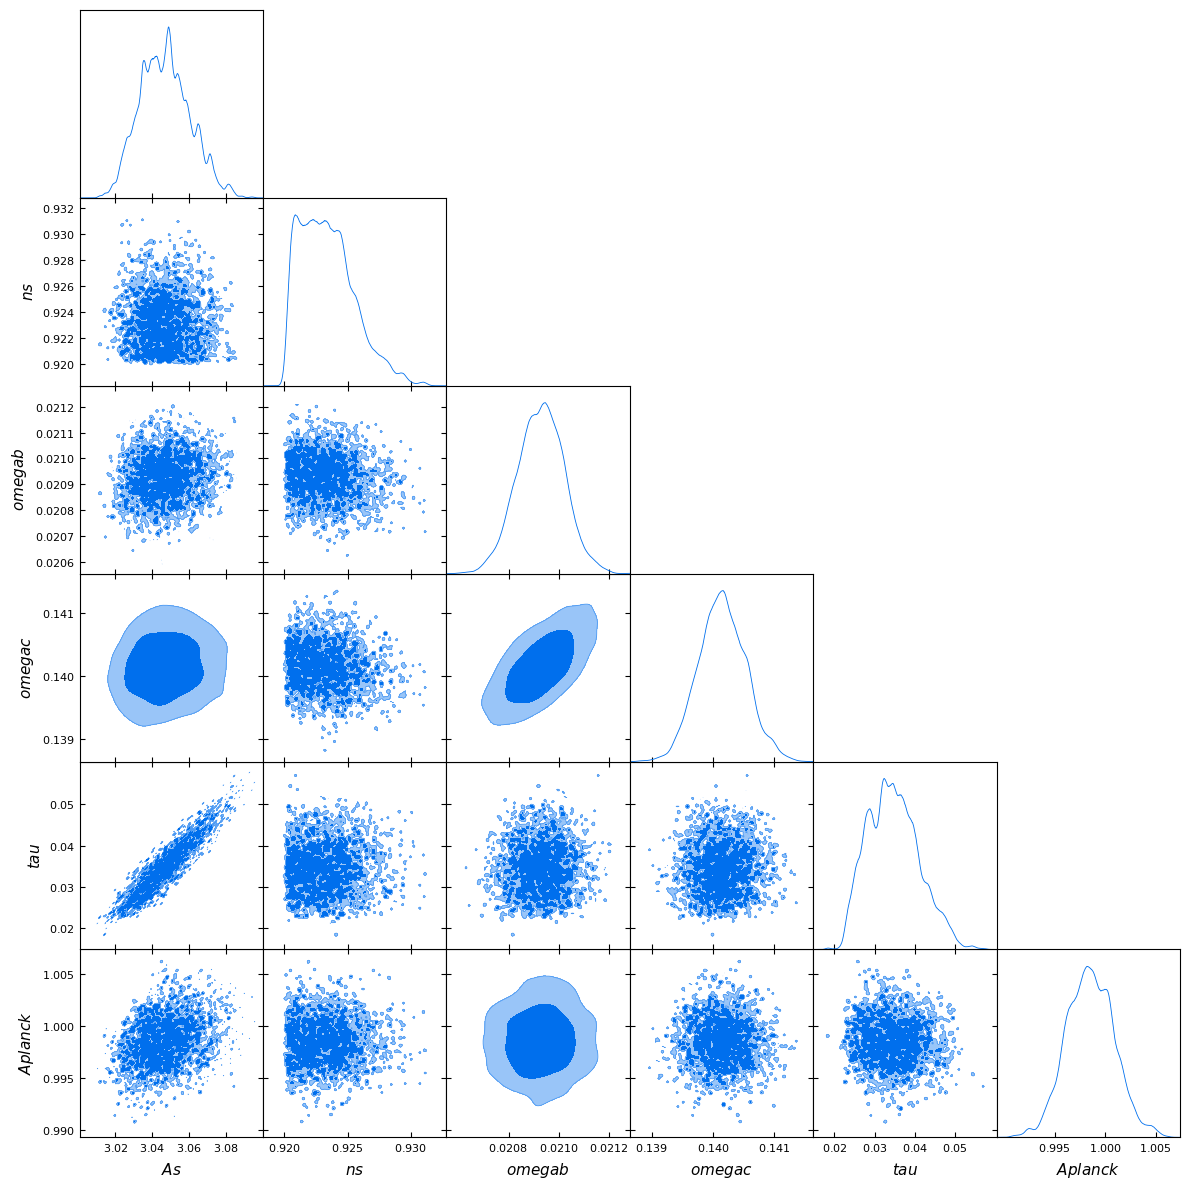

In [ ]:
# -------------------------------- LOW -------------------------------- #

#input_test = np.array([3.054, 0.9626, 67, 0.02233, 0.1207, 0.057, 1.00])
input_low = np.array([3.054, 0.9626, 0.02233, 0.1207, 0.057, 1.00])
TT2018 = PlanckLitePy(data_directory='data', year=2018, spectra='TT', use_low_ell_bins=False)
plt.rcParams['text.usetex'] = False
Capse_TT = jaxcapse.load_emulator("../trained_emu/TT/")
Capse_EE = jaxcapse.load_emulator("../trained_emu/EE/")
Capse_TE = jaxcapse.load_emulator("../trained_emu/TE/")
Capse_PP = jaxcapse.load_emulator("../trained_emu/PP/")
lsTT = np.arange(2,2509)
lsTE = np.arange(2,1997)

def call_emu_planck_low(input, Capse_TT, Capse_TE, Capse_EE):
    #cosmo_input = input[0:6]
    #Ap = input[6]
    As, ns, omegab, omegac, tau = input[0:5]
    Ap = input[5]

    cosmoinput = np.array([As, ns, 59, omegab, omegac, tau])

    
    Dl_TT = Capse_TT.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_TE = Capse_TE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_EE = Capse_EE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    return Dl_TT, Dl_TE, Dl_EE

def create_emu_planck_function_low(Capse_TT, Capse_TE, Capse_EE):
    return partial(call_emu_planck_low, Capse_TT=Capse_TT, Capse_TE=Capse_TE, Capse_EE=Capse_EE)
emu_planck_fn = create_emu_planck_function_low(Capse_TT, Capse_TE, Capse_EE)
TTTEEE2018_lowTTbins=PlanckLitePy(data_directory='data', year=2018, spectra='TTTEEE', use_low_ell_bins=False)
ellmin = 2
Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input_low)
#loglike=TTTEEE2018_lowTTbins.loglike(Dl_TT, Dl_TE, Dl_EE, ellmin)
def loglike_low(input):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input)
    return TTTEEE2018_lowTTbins.loglike(Dl_TT, Dl_TE, Dl_EE, ellmin)

prior = pc.Prior([uniform(2.5, 1.),
                 uniform(0.92, 1.0-0.92),
                 #uniform(63, 9),
                 uniform(0.01985, 0.025-0.01985),
                 uniform(0.10, 0.15-0.1),
                 norm(0.0506, 0.0086),
                 norm(1.0, 0.0025)])


sampler_low = pc.Sampler(
    prior=prior,
    likelihood=loglike_low,
    vectorize=False,
    random_state=0
)

sampler_low.run()
samples_low, logl_low, logp_low = sampler_low.posterior(resample=True)
np.save("pocosamples_low2", samples_low)
np.save("pocolike_low2", logl_low)
np.save("pocoprior_low2", logp_low)

samples_low = np.load("pocosamples_low2.npy")
lprior_low = np.load("pocoprior_low2.npy")
mlprior_low = -lprior_low
llike_low = np.load("pocolike_low2.npy")
mllike_low = -llike_low
lpost_low = lprior_low + llike_low
mlpost_low = -lpost_low

fullshape_low = (np.shape(samples_low)[0], np.shape(samples_low)[1]+3)
fullsamples_low= np.zeros(fullshape_low)

for i in range(np.shape(samples_low)[0]):
    for j in range(np.shape(samples_low)[1]):
        fullsamples_low[i][j] = samples_low[i][j]
        fullsamples_low[i][np.shape(samples_low)[1]] = mlpost_low[i]
        fullsamples_low[i][np.shape(samples_low)[1]+1] = mlprior_low[i]
        fullsamples_low[i][np.shape(samples_low)[1]+2] = 1.0

names=['As', 'ns','omegab','omegac','tau', 'Aplanck']                    
    
gdsamples_low = MCSamples(samples=samples_low, names = names, labels = names
                      )      

g = plots.get_subplot_plotter()
g.triangle_plot(gdsamples_low, filled=True#, markers={'a':params[2],'b':params[1],'c':params[0]}
                                                                                )

#create txt

fullnames = []
for i in range(np.shape(samples_low)[1]):
    fullnames.append(names[i])
fullnames.append('minuslogpost')
fullnames.append('minuslogprior')
fullnames.append('weight')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dfpoco_low = pd.DataFrame(data=fullsamples_low, columns=fullnames)


#this seems correct
with open('pocosamples_low2.txt', mode='w') as file_object:
    print(dfpoco_low.to_string(index=False), file=file_object)
#DONT FORGET TO INSERT A # IN THE FIRST TXT POSITION IN THE FILE

















































































































































































































































































































Iter: 41it [4:53:44, 429.87s/it, beta=1, calls=61184, ESS=4036, logZ=-415, logP=-380, acc=0.781, steps=9, eff=1]


Removed no burn in


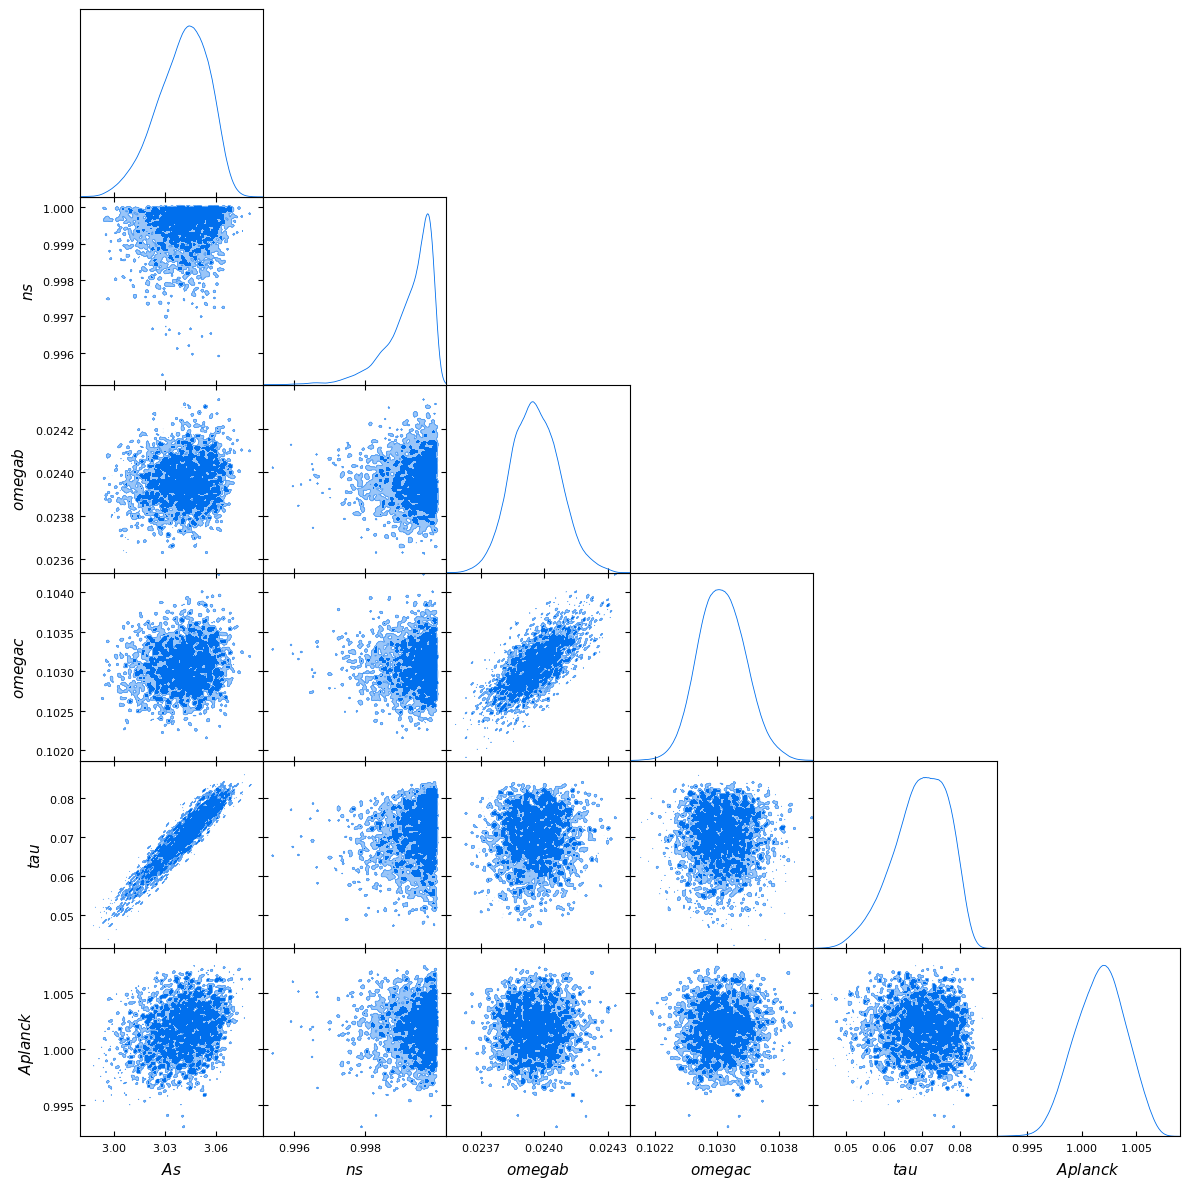

In [ ]:
# -------------------------------- HIGH -------------------------------- #

#input_test = np.array([3.054, 0.9626, 67, 0.02233, 0.1207, 0.057, 1.00])
input_high = np.array([3.054, 0.9626, 0.02233, 0.1207, 0.057, 1.00])
TT2018 = PlanckLitePy(data_directory='data', year=2018, spectra='TT', use_low_ell_bins=False)
plt.rcParams['text.usetex'] = False
Capse_TT = jaxcapse.load_emulator("../trained_emu/TT/")
Capse_EE = jaxcapse.load_emulator("../trained_emu/EE/")
Capse_TE = jaxcapse.load_emulator("../trained_emu/TE/")
Capse_PP = jaxcapse.load_emulator("../trained_emu/PP/")
lsTT = np.arange(2,2509)
lsTE = np.arange(2,1997)

def call_emu_planck_high(input, Capse_TT, Capse_TE, Capse_EE):
    #cosmo_input = input[0:6]
    #Ap = input[6]
    As, ns, omegab, omegac, tau = input[0:5]
    Ap = input[5]

    cosmoinput = np.array([As, ns, 76, omegab, omegac, tau])

    
    Dl_TT = Capse_TT.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_TE = Capse_TE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_EE = Capse_EE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    return Dl_TT, Dl_TE, Dl_EE

def create_emu_planck_function_high(Capse_TT, Capse_TE, Capse_EE):
    return partial(call_emu_planck_high, Capse_TT=Capse_TT, Capse_TE=Capse_TE, Capse_EE=Capse_EE)
emu_planck_fn = create_emu_planck_function_high(Capse_TT, Capse_TE, Capse_EE)
TTTEEE2018_lowTTbins=PlanckLitePy(data_directory='data', year=2018, spectra='TTTEEE', use_low_ell_bins=False)
ellmin = 2
Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input_high)
#loglike=TTTEEE2018_lowTTbins.loglike(Dl_TT, Dl_TE, Dl_EE, ellmin)
def loglike_high(input):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input)
    return TTTEEE2018_lowTTbins.loglike(Dl_TT, Dl_TE, Dl_EE, ellmin)

prior = pc.Prior([uniform(2.5, 1.),
                 uniform(0.92, 1.0-0.92),
                 #uniform(63, 9),
                 uniform(0.01985, 0.025-0.01985),
                 uniform(0.10, 0.15-0.1),
                 norm(0.0506, 0.0086),
                 norm(1.0, 0.0025)])


sampler_high = pc.Sampler(
    prior=prior,
    likelihood=loglike_high,
    vectorize=False,
    random_state=0
)

sampler_high.run()
samples_high, logl_high, logp_high = sampler_high.posterior(resample=True)
np.save("pocosamples_high2", samples_high)
np.save("pocolike_high2", logl_high)
np.save("pocoprior_high2", logp_high)

samples_high = np.load("pocosamples_high2.npy")
lprior_high = np.load("pocoprior_high2.npy")
mlprior_high = -lprior_high
llike_high = np.load("pocolike_high2.npy")
mllike_high = -llike_high
lpost_high = lprior_high + llike_high
mlpost_high = -lpost_high

fullshape_high = (np.shape(samples_high)[0], np.shape(samples_high)[1]+3)
fullsamples_high= np.zeros(fullshape_high)

for i in range(np.shape(samples_high)[0]):
    for j in range(np.shape(samples_high)[1]):
        fullsamples_high[i][j] = samples_high[i][j]
        fullsamples_high[i][np.shape(samples_high)[1]] = mlpost_high[i]
        fullsamples_high[i][np.shape(samples_high)[1]+1] = mlprior_high[i]
        fullsamples_high[i][np.shape(samples_high)[1]+2] = 1.0

names=['As', 'ns','omegab','omegac','tau', 'Aplanck']                    
    
gdsamples_high = MCSamples(samples=samples_high, names = names, labels = names
                      )      

g = plots.get_subplot_plotter()
g.triangle_plot(gdsamples_high, filled=True#, markers={'a':params[2],'b':params[1],'c':params[0]}
                                                                                )

#create txt

fullnames = []
for i in range(np.shape(samples_high)[1]):
    fullnames.append(names[i])
fullnames.append('minuslogpost')
fullnames.append('minuslogprior')
fullnames.append('weight')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dfpoco_high = pd.DataFrame(data=fullsamples_high, columns=fullnames)


#this seems correct
with open('pocosamples_high2.txt', mode='w') as file_object:
    print(dfpoco_high.to_string(index=False), file=file_object)
#DONT FORGET TO INSERT A # IN THE FIRST TXT POSITION IN THE FILE


Removed no burn in


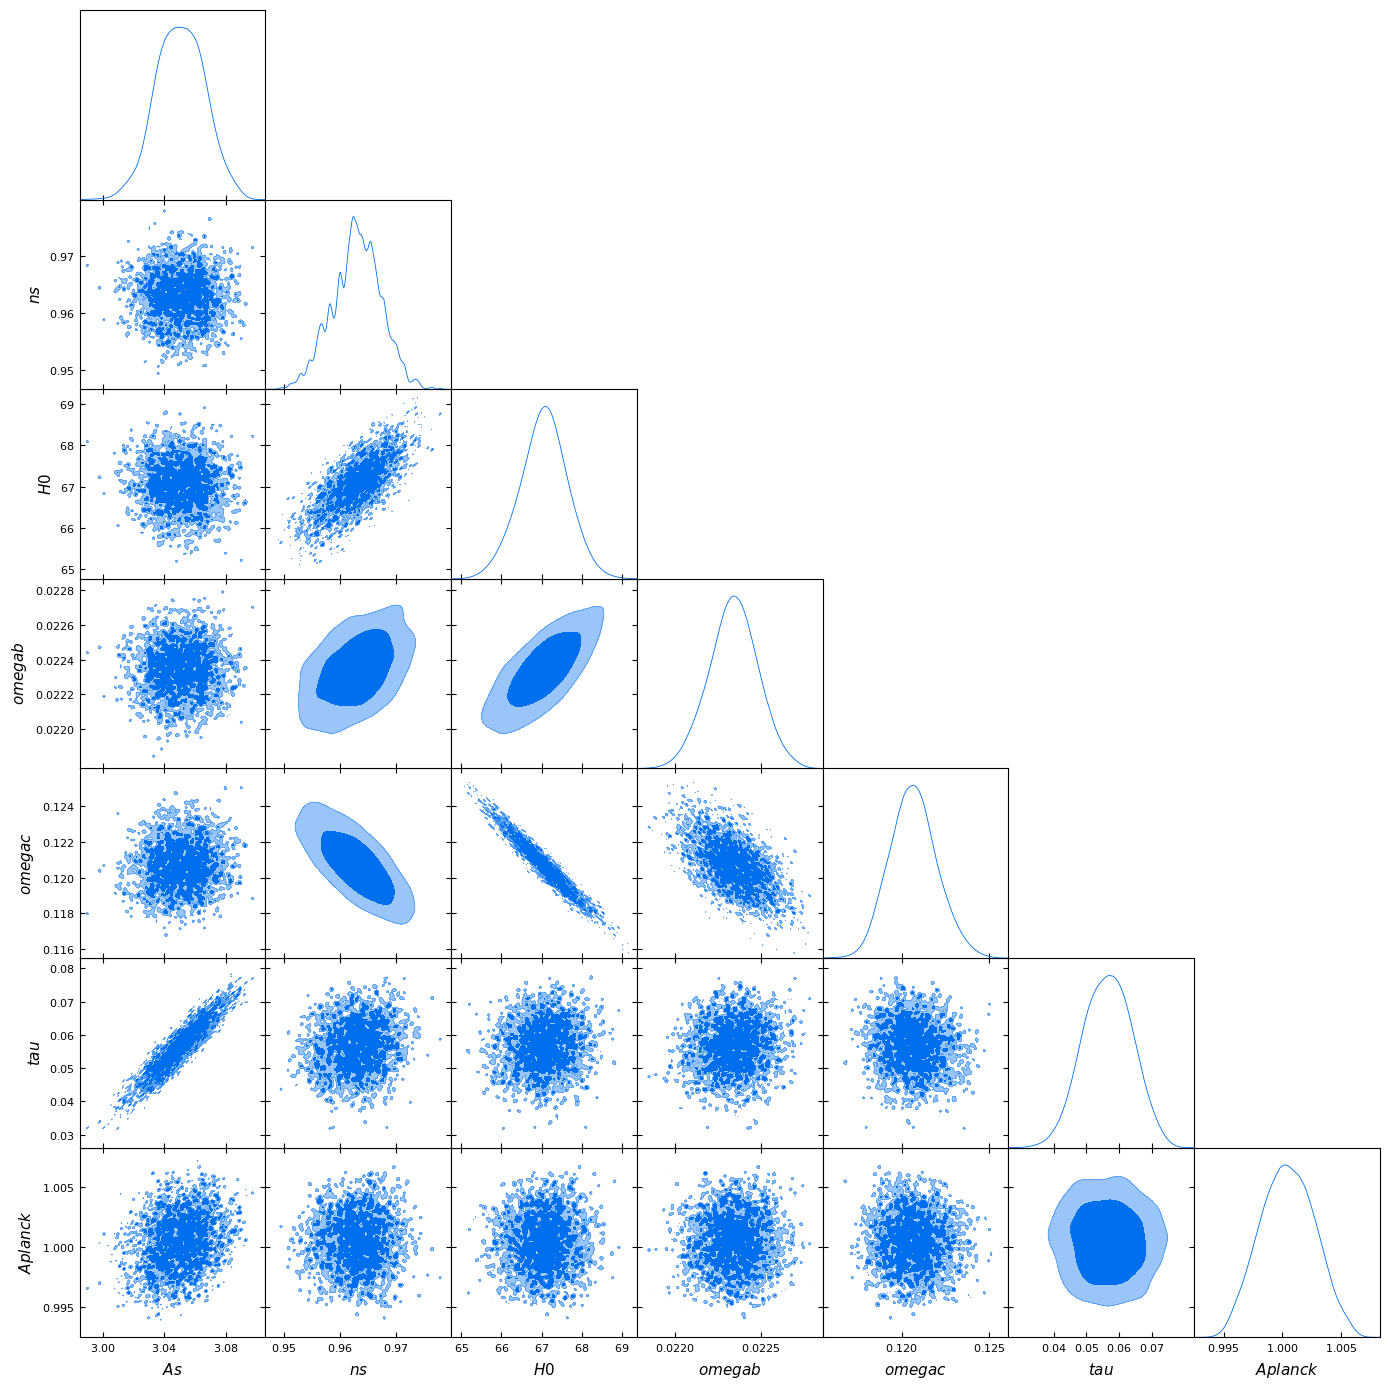

In [ ]:
# plot test i think
import pandas as pd

samples = np.load("pocosamples.npy")
lprior = np.load("pocoprior.npy")
mlprior = -lprior
llike = np.load("pocolike.npy")
mllike = -llike
lpost = lprior + llike
mlpost = -lpost

fullshape = (np.shape(samples)[0], np.shape(samples)[1]+3)
fullsamples= np.zeros(fullshape)

for i in range(np.shape(samples)[0]):
    for j in range(np.shape(samples)[1]):
        fullsamples[i][j] = samples[i][j]
        fullsamples[i][np.shape(samples)[1]] = mlpost[i]
        fullsamples[i][np.shape(samples)[1]+1] = mlprior[i]
        fullsamples[i][np.shape(samples)[1]+2] = 1.0

names=['As', 'ns', 'H0','omegab','omegac','tau', 'Aplanck']                    
    
gdsamples = MCSamples(samples=samples, names = names, labels = names
                      )      

g = plots.get_subplot_plotter()
g.triangle_plot(gdsamples, filled=True#, markers={'a':params[2],'b':params[1],'c':params[0]}
                                                                                )

#create txt

fullnames = []
for i in range(np.shape(samples)[1]):
    fullnames.append(names[i])
fullnames.append('minuslogpost')
fullnames.append('minuslogprior')
fullnames.append('weight')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dfpoco1 = pd.DataFrame(data=fullsamples, columns=fullnames)


#this seems correct
with open('pocosamples1.txt', mode='w') as file_object:
    print(dfpoco1.to_string(index=False), file=file_object)
#DONT FORGET TO INSERT A # IN THE FIRST TXT POSITION IN THE FILE


Computing evidence for model:  fid
Computing evidence for model:  low
Computing evidence for model:  high


Removed no burn in


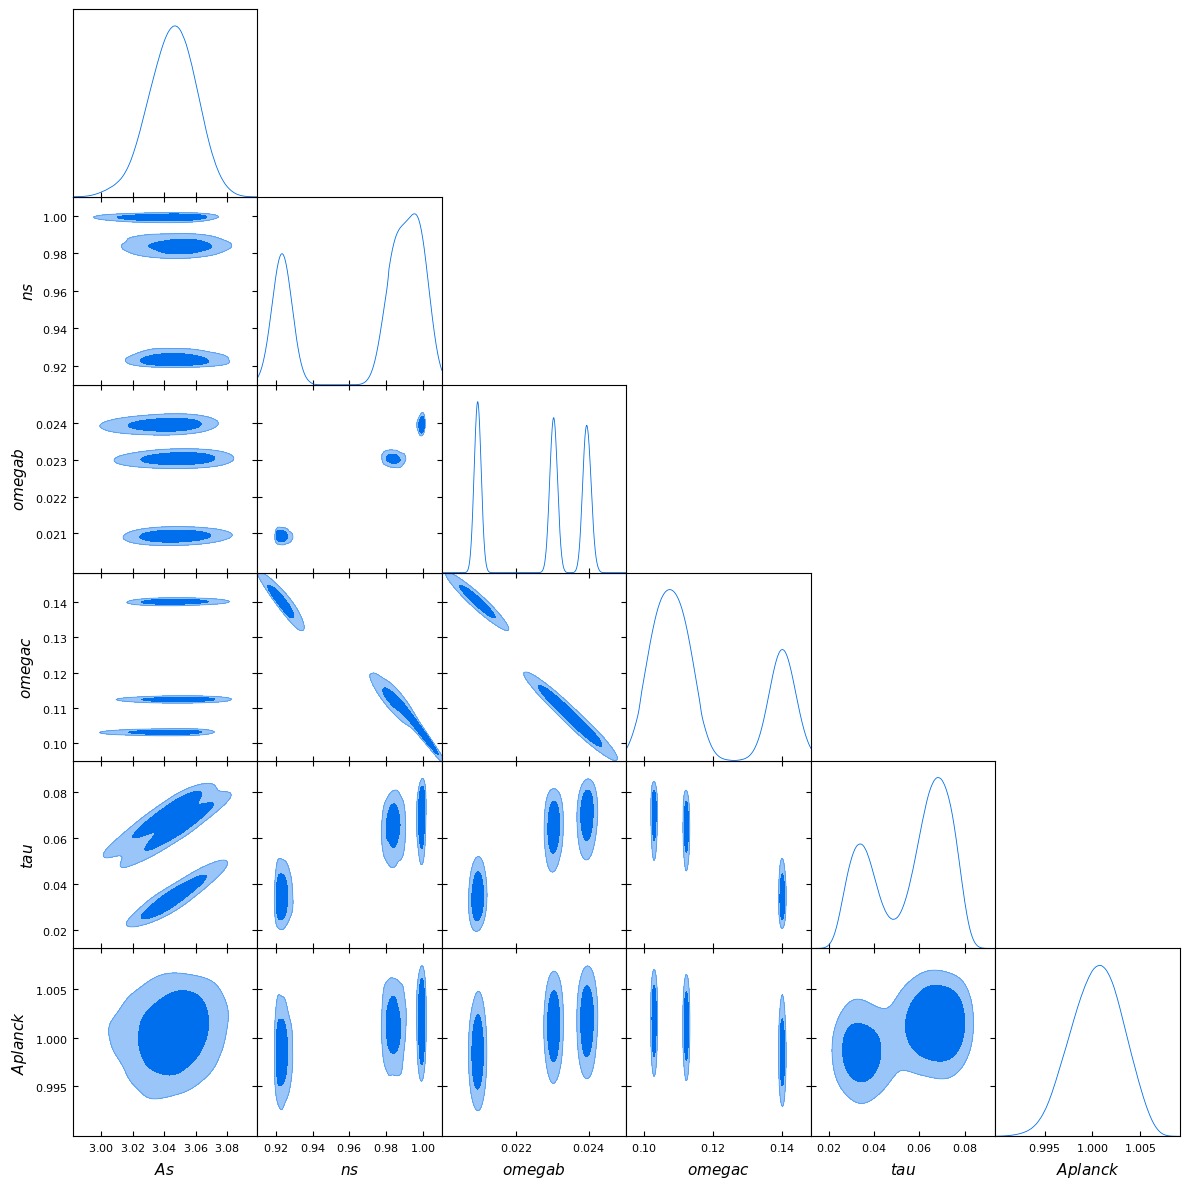

In [4]:
# --------------------- Bayesian Model Averaging --------------------- #
from getdist.plots import GetDistPlotter

names = ['As', 'ns','omegab','omegac','tau', 'Aplanck']
roots = ["\pocosamples_fid2_comp","\pocosamples_low2","\pocosamples_high2"] # this might not be correct
models = ["fid","low","high"]
temperature = {'fid': 1,'low': 1,'high': 1}
model_prior = {'fid': 0.3,'low': 0.3, 'high': 0.3}
parameters = {'fid':names, 'low': names, 'high': names}        #these have to match the parameter names in the .txt
burnin = [0.3, 0.3, 0.3]
chainpath = "C:/Users/zombk/Desktop/pocomc_cross_nuts/planck-lite-py/samplestxt2"

out = fmpc.runbma(roots=roots, models=models, chainDir=chainpath, burnin=burnin,
            priors=model_prior, temperature=temperature, pars=parameters, estimator='learnt harmonic')


#CREATE AND PLOT BMA -----------------
outnewchains=out['newchains']['Reweighted']
length = np.shape(outnewchains['As'])[0]
arraybma = np.zeros(shape=(length, 6))      #change 3/4 is adding/taking away weight column

newweights = outnewchains['weight'].to_numpy() 

for i in range(length):
    arraybma[i][0] = outnewchains['As'][i]
    arraybma[i][1] = outnewchains['ns'][i]
    #arraybma[i][2] = outnewchains['H0'][i]
    arraybma[i][2] = outnewchains['omegab'][i]
    arraybma[i][3] = outnewchains['omegac'][i]
    arraybma[i][4] = outnewchains['tau'][i]
    arraybma[i][5] = outnewchains['Aplanck'][i]

MCbmasamples = MCSamples(samples=arraybma, weights=newweights, names = names, labels=names, label="BMA")

g = GetDistPlotter()
    # Add the sample to the plotter
g.triangle_plot([MCbmasamples], filled=True#, markers={'c':params[0], 'b':params[1], 'a':params[2]}
                )
# Show the plot
plt.show()

In [6]:
# --------------------------------- FID elpds --------------------------------- #
#calculate lppds and elpds
import numpy as np
from tqdm import tqdm
import nfcof_arviz4_dense as na

# LOO fid
#fid_samp = np.load("pocosamples_fid2.npy") #doesn't exist

# -------------------------- just because I don't want to run the whole thing again
input_fid = np.array([3.054, 0.9626, 0.02233, 0.1207, 0.057, 1.00])
Capse_TT = jaxcapse.load_emulator("../trained_emu/TT/")
Capse_EE = jaxcapse.load_emulator("../trained_emu/EE/")
Capse_TE = jaxcapse.load_emulator("../trained_emu/TE/")
Capse_PP = jaxcapse.load_emulator("../trained_emu/PP/")
lsTT = np.arange(2,2509)
lsTE = np.arange(2,1997)

def call_emu_planck_fid(input, Capse_TT, Capse_TE, Capse_EE):
    #cosmo_input = input[0:6]
    #Ap = input[6]
    As, ns, omegab, omegac, tau = input[0:5]
    Ap = input[5]

    cosmoinput = np.array([As, ns, 67, omegab, omegac, tau])

    
    Dl_TT = Capse_TT.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_TE = Capse_TE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_EE = Capse_EE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    return Dl_TT, Dl_TE, Dl_EE

def create_emu_planck_function_fid(Capse_TT, Capse_TE, Capse_EE):
    return partial(call_emu_planck_fid, Capse_TT=Capse_TT, Capse_TE=Capse_TE, Capse_EE=Capse_EE)
emu_planck_fn = create_emu_planck_function_fid(Capse_TT, Capse_TE, Capse_EE)
TTTEEE2018_lowTTbins=PlanckLitePy(data_directory='data', year=2018, spectra='TTTEEE', use_low_ell_bins=False)
ellmin = 2
Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input_fid)
#loglike=TTTEEE2018_lowTTbins.loglike(Dl_TT, Dl_TE, Dl_EE, ellmin)
# --------------------------

num_data = 2507 #let's say its this for now, this number comes from the above code, next to cosmoinput in (def) call_emu_plank_fid
num_samples = 4403 #from the txt file, prob a better way of getting this, esp from .npy which I didn't get for fid 
log_weights = np.zeros((num_data, num_samples))
PLLs = np.zeros((num_data, num_samples))
lprior = np.load("pocoprior_fid2_comp.npy")
llike = np.load("pocolike_fid2_comp.npy")
chains = np.load("pocosamples_fid2_comp.npy") #might have to do one extra thing here to get the proper samples? not sure though # effectively flat_samples
post_log_lik = lprior+llike
post_log_lik = post_log_lik*(-1)


#print("firstloop")

def loglike_fid_LOO_2(Dl_TT, Dl_TE, Dl_EE, i):
    return TTTEEE2018_lowTTbins.loglike_LOO(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

def PLL_2(Dl_TT, Dl_TE, Dl_EE, i):
    return TTTEEE2018_lowTTbins.PLL(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

for s in range(num_samples):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(chains[s])
    for i in tqdm(range(num_data), position = 0, leave = True):
        """
        This is the slowest step, but I've made it about 30% faster than the version for the paper
        I'm sure some thinking could make it much faster, but it works correctly here
        """

        log_weights[i,s] = loglike_fid_LOO_2(Dl_TT, Dl_TE, Dl_EE, i) - post_log_lik[s]
        #print("logweights")

        PLLs[i,s] = PLL_2(Dl_TT, Dl_TE, Dl_EE, i)
        #print("PLLs")


ess_p = na.ess(post_log_lik, method="mean")
reff = (
    np.hstack([ess_p[v].values.flatten() for v in ess_p.data_vars]).mean() / (num_data-1)
)
print("Applying PSIS on {} data points".format(num_data))
for i in tqdm(range(num_data), position = 0, leave = True):
# replace each weight with the pareto-smoothed weight from this function az.psislw()
    temp_log_psis, k = az.psislw(log_weights[i,:], reff)
    log_weights[i,:] = temp_log_psis

    if k > 0.7:
        print("Data Index {} returned Pareto shape k = {}. Please check!".format(i, k))

weightedPLLs = np.zeros((num_data, num_samples))
explppds_fid = np.zeros(num_data)
weights = np.exp(log_weights)
#print("weights: "+str(weights))
sumweights = np.zeros(num_data)
expPLL = np.exp(PLLs)

for i in range(num_data):
    for s in range(num_samples):
        weightedPLLs[i][s] = weights[i][s]*expPLL[i][s]
    explppds_fid[i] = np.sum(weightedPLLs[i])
    sumweights[i] = np.sum(weights[i])
    explppds_fid[i] = explppds_fid[i]/sumweights[i]

elpd_fid = np.sum(np.log(explppds_fid))

np.save("pocoelpd_fid2_comp",explppds_fid)
np.save("pocoexplppds_fid2_comp",explppds_fid)





 64%|██████▍   | 1614/2507 [02:42<01:29,  9.95it/s]


KeyboardInterrupt: 

In [8]:
# --------------------------------- FID elpds (arviz approximation) --------------------------------- #
#calculate lppds and elpds
import numpy as np
from tqdm import tqdm
import nfcof_arviz4_dense as na
import warnings

# LOO fid
#fid_samp = np.load("pocosamples_fid2.npy") #doesn't exist

# -------------------------- just because I don't want to run the whole thing again
input_fid = np.array([3.054, 0.9626, 0.02233, 0.1207, 0.057, 1.00])
Capse_TT = jaxcapse.load_emulator("../trained_emu/TT/")
Capse_EE = jaxcapse.load_emulator("../trained_emu/EE/")
Capse_TE = jaxcapse.load_emulator("../trained_emu/TE/")
Capse_PP = jaxcapse.load_emulator("../trained_emu/PP/")
lsTT = np.arange(2,2509)
lsTE = np.arange(2,1997)

def call_emu_planck_fid(input, Capse_TT, Capse_TE, Capse_EE):
    #cosmo_input = input[0:6]
    #Ap = input[6]
    As, ns, omegab, omegac, tau = input[0:5]
    Ap = input[5]

    cosmoinput = np.array([As, ns, 71, omegab, omegac, tau]) #changed fid from 67 to 71

    
    Dl_TT = Capse_TT.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_TE = Capse_TE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_EE = Capse_EE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    return Dl_TT, Dl_TE, Dl_EE

def create_emu_planck_function_fid(Capse_TT, Capse_TE, Capse_EE):
    return partial(call_emu_planck_fid, Capse_TT=Capse_TT, Capse_TE=Capse_TE, Capse_EE=Capse_EE)
emu_planck_fn = create_emu_planck_function_fid(Capse_TT, Capse_TE, Capse_EE)
TTTEEE2018_lowTTbins=PlanckLitePy(data_directory='data', year=2018, spectra='TTTEEE', use_low_ell_bins=False)
ellmin = 2
Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input_fid)
#loglike=TTTEEE2018_lowTTbins.loglike(Dl_TT, Dl_TE, Dl_EE, ellmin)
# --------------------------

num_data = 2507 #let's say its this for now, this number comes from the above code, next to cosmoinput in (def) call_emu_plank_fid
num_samples = 4403 #from the txt file, prob a better way of getting this, esp from .npy which I didn't get for fid 
log_weights = np.zeros((num_data, num_samples))
PLLs = np.zeros((num_data, num_samples))
lprior = np.load("pocoprior_fid2_comp.npy")
llike = np.load("pocolike_fid2_comp.npy")
chains = np.load("pocosamples_fid2_comp.npy") #might have to do one extra thing here to get the proper samples? not sure though # effectively flat_samples
post_log_lik = lprior+llike
post_log_lik = post_log_lik*(-1)


#print("firstloop")
'''
def loglike_fid_LOO_2(Dl_TT, Dl_TE, Dl_EE, i):
    return TTTEEE2018_lowTTbins.loglike_LOO(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

def PLL_2(Dl_TT, Dl_TE, Dl_EE, i):
    return TTTEEE2018_lowTTbins.PLL(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

for s in range(num_samples):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(chains[s])
    for i in tqdm(range(num_data), position = 0, leave = True):
        """
        This is the slowest step, but I've made it about 30% faster than the version for the paper
        I'm sure some thinking could make it much faster, but it works correctly here
        """

        log_weights[i,s] = loglike_fid_LOO_2(Dl_TT, Dl_TE, Dl_EE, i) - post_log_lik[s]
        #print("logweights")

        PLLs[i,s] = PLL_2(Dl_TT, Dl_TE, Dl_EE, i)
        #print("PLLs")
'''

ess_p = na.ess(post_log_lik, method="mean")
reff = (
    ess_p / (num_data-1)
)
log_weightsfid, pareto_shapefid = az.psislw(-llike, reff)
log_weightsfid += llike
warn_mg = False
good_k = min(1 - 1 / np.log10(num_samples), 0.7)

if np.any(pareto_shapefid > good_k):
    warnings.warn(
    f"Estimated shape parameter of Pareto distribution is greater than {good_k:.2f} "
    "for one or more samples. You should consider using a more robust model, this is "
    "because importance sampling is less likely to work well if the marginal posterior "
    "and LOO posterior are very different. This is more likely to happen with a "
    "non-robust model and highly influential observations."
        )
    warn_mg = True

scale_value=1
scale = "log"
pointwise = True
ufunc_kwargs = {"n_dims": 1, "ravel": False}
kwargs = {"input_core_dims": [["__sample__"]]}
loo_lppd_i = scale_value * na._wrap_xarray_ufunc(
    na._logsumexp, log_weightsfid, ufunc_kwargs=ufunc_kwargs, **kwargs
)
loo_lppd_fid = loo_lppd_i
#loo_lppd_se = (num_data * np.var(loo_lppd_i.values)) ** 0.5

lppd = np.sum(
    na._wrap_xarray_ufunc(
        na._logsumexp,
        llike,
        func_kwargs={"b_inv": num_samples},
        ufunc_kwargs=ufunc_kwargs,
        **kwargs,
    )
)
p_loo = lppd - loo_lppd_fid / scale_value

np.save("loolppd_fid2_comp",loo_lppd_fid)



In [15]:
loo_lppd_fid

-294.91858488431006

In [ ]:
# --------------------------------- LOW elpds --------------------------------- #
# THINGS THAT MUST BE CHANGED:
# - every instance of 'fid', to the proper model name
# - the set number for H0 in 'cosmoinput', within 'call_emu_planck_(model)'
# - 'num_samples' value, comes from length of .txt file

#calculate lppds and elpds
import numpy as np
from tqdm import tqdm
import nfcof_arviz4_dense as na

# LOO low

# -------------------------- just because I don't want to run the whole thing again
input_low = np.array([3.054, 0.9626, 0.02233, 0.1207, 0.057, 1.00])  #same as input_fid, doesn't really matter
Capse_TT = jaxcapse.load_emulator("../trained_emu/TT/")
Capse_EE = jaxcapse.load_emulator("../trained_emu/EE/")
Capse_TE = jaxcapse.load_emulator("../trained_emu/TE/")
Capse_PP = jaxcapse.load_emulator("../trained_emu/PP/")
lsTT = np.arange(2,2509)
lsTE = np.arange(2,1997)

def call_emu_planck_low(input, Capse_TT, Capse_TE, Capse_EE):
    #cosmo_input = input[0:6]
    #Ap = input[6]
    As, ns, omegab, omegac, tau = input[0:5]
    Ap = input[5]

    cosmoinput = np.array([As, ns, 59, omegab, omegac, tau])

    
    Dl_TT = Capse_TT.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_TE = Capse_TE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_EE = Capse_EE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    return Dl_TT, Dl_TE, Dl_EE

def create_emu_planck_function_low(Capse_TT, Capse_TE, Capse_EE):
    return partial(call_emu_planck_low, Capse_TT=Capse_TT, Capse_TE=Capse_TE, Capse_EE=Capse_EE)
emu_planck_fn = create_emu_planck_function_low(Capse_TT, Capse_TE, Capse_EE)
TTTEEE2018_lowTTbins=PlanckLitePy(data_directory='data', year=2018, spectra='TTTEEE', use_low_ell_bins=False)
ellmin = 2
Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input_low)
#loglike=TTTEEE2018_lowTTbins.loglike(Dl_TT, Dl_TE, Dl_EE, ellmin)
def loglike_low_LOO(input, i):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input)
    return TTTEEE2018_lowTTbins.loglike_LOO(Dl_TT, Dl_TE, Dl_EE, i, ellmin)
# --------------------------

num_data = 2507 #let's say its this for now, this number comes from the above code, next to cosmoinput in (def) call_emu_plank_fid
num_samples = 4552 #from the txt file
log_weights = np.zeros((num_data, num_samples))
PLLs = np.zeros((num_data, num_samples))
lprior = np.load("pocoprior_low2.npy")
llike = np.load("pocolike_low2.npy")
chains = np.load("pocosamples_low2.npy") #might have to do one extra thing here to get the proper samples? not sure though # effectively flat_samples
post_log_lik = lprior+llike
post_log_lik = post_log_lik*(-1)

def PLL(input, i):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input)
    return TTTEEE2018_lowTTbins.PLL(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

def loglike_low_LOO_2(Dl_TT, Dl_TE, Dl_EE, i):
    return TTTEEE2018_lowTTbins.loglike_LOO(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

def PLL_2(Dl_TT, Dl_TE, Dl_EE, i):
    return TTTEEE2018_lowTTbins.PLL(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

#print("firstloop")
for s in range(num_samples):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(chains[s])
    for i in tqdm(range(num_data), position = 0, leave = True):
        """
        This is the slowest step, but I've made it about 30% faster than the version for the paper
        I'm sure some thinking could make it much faster, but it works correctly here
        """

        log_weights[i,s] = loglike_low_LOO_2(Dl_TT, Dl_TE, Dl_EE, i)  - post_log_lik[s]
        #print("logweights")
        
        PLLs[i,s] = PLL_2(Dl_TT, Dl_TE, Dl_EE, i) 
        #print("PLLs")


ess_p = na.ess(post_log_lik, method="mean")
reff = (
    np.hstack([ess_p[v].values.flatten() for v in ess_p.data_vars]).mean() / (num_data-1)
)
print("Applying PSIS on {} data points".format(num_data))
for i in tqdm(range(num_data), position = 0, leave = True):
# replace each weight with the pareto-smoothed weight from this function az.psislw()
    temp_log_psis, k = az.psislw(log_weights[i,:], reff)
    log_weights[i,:] = temp_log_psis

    if k > 0.7:
        print("Data Index {} returned Pareto shape k = {}. Please check!".format(i, k))

weightedPLLs = np.zeros((num_data, num_samples))
explppds_low = np.zeros(num_data)
weights = np.exp(log_weights)
#print("weights: "+str(weights))
sumweights = np.zeros(num_data)
expPLL = np.exp(PLLs)

for i in range(num_data):
    for s in range(num_samples):
        weightedPLLs[i][s] = weights[i][s]*expPLL[i][s]
    explppds_low[i] = np.sum(weightedPLLs[i])
    sumweights[i] = np.sum(weights[i])
    explppds_low[i] = explppds_low[i]/sumweights[i]

elpd_low = np.sum(np.log(explppds_low))

np.save("pocoelpd_low2",elpd_low)
np.save("pocoexplppds_low2",explppds_low)





In [3]:
# --------------------------------- LOW elpds (arviz approximation) --------------------------------- #
# THINGS THAT MUST BE CHANGED:
# - every instance of 'fid', to the proper model name
# - the set number for H0 in 'cosmoinput', within 'call_emu_planck_(model)'
# - 'num_samples' value, comes from length of .txt file

#calculate lppds and elpds
import numpy as np
from tqdm import tqdm
import nfcof_arviz4_dense as na

# LOO low

# -------------------------- just because I don't want to run the whole thing again
input_low = np.array([3.054, 0.9626, 0.02233, 0.1207, 0.057, 1.00])  #same as input_fid, doesn't really matter
Capse_TT = jaxcapse.load_emulator("../trained_emu/TT/")
Capse_EE = jaxcapse.load_emulator("../trained_emu/EE/")
Capse_TE = jaxcapse.load_emulator("../trained_emu/TE/")
Capse_PP = jaxcapse.load_emulator("../trained_emu/PP/")
lsTT = np.arange(2,2509)
lsTE = np.arange(2,1997)

def call_emu_planck_low(input, Capse_TT, Capse_TE, Capse_EE):
    #cosmo_input = input[0:6]
    #Ap = input[6]
    As, ns, omegab, omegac, tau = input[0:5]
    Ap = input[5]

    cosmoinput = np.array([As, ns, 59, omegab, omegac, tau])

    
    Dl_TT = Capse_TT.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_TE = Capse_TE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_EE = Capse_EE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    return Dl_TT, Dl_TE, Dl_EE

def create_emu_planck_function_low(Capse_TT, Capse_TE, Capse_EE):
    return partial(call_emu_planck_low, Capse_TT=Capse_TT, Capse_TE=Capse_TE, Capse_EE=Capse_EE)
emu_planck_fn = create_emu_planck_function_low(Capse_TT, Capse_TE, Capse_EE)
TTTEEE2018_lowTTbins=PlanckLitePy(data_directory='data', year=2018, spectra='TTTEEE', use_low_ell_bins=False)
ellmin = 2
Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input_low)
#loglike=TTTEEE2018_lowTTbins.loglike(Dl_TT, Dl_TE, Dl_EE, ellmin)
def loglike_low_LOO(input, i):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input)
    return TTTEEE2018_lowTTbins.loglike_LOO(Dl_TT, Dl_TE, Dl_EE, i, ellmin)
# --------------------------

num_data = 2507 #let's say its this for now, this number comes from the above code, next to cosmoinput in (def) call_emu_plank_fid
num_samples = 4552 #from the txt file
log_weights = np.zeros((num_data, num_samples))
PLLs = np.zeros((num_data, num_samples))
lprior = np.load("pocoprior_low2.npy")
llike = np.load("pocolike_low2.npy")
chains = np.load("pocosamples_low2.npy") #might have to do one extra thing here to get the proper samples? not sure though # effectively flat_samples
post_log_lik = lprior+llike
post_log_lik = post_log_lik*(-1)

'''
def PLL(input, i):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input)
    return TTTEEE2018_lowTTbins.PLL(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

def loglike_low_LOO_2(Dl_TT, Dl_TE, Dl_EE, i):
    return TTTEEE2018_lowTTbins.loglike_LOO(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

def PLL_2(Dl_TT, Dl_TE, Dl_EE, i):
    return TTTEEE2018_lowTTbins.PLL(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

#print("firstloop")
for s in range(num_samples):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(chains[s])
    for i in tqdm(range(num_data), position = 0, leave = True):
        """
        This is the slowest step, but I've made it about 30% faster than the version for the paper
        I'm sure some thinking could make it much faster, but it works correctly here
        """

        log_weights[i,s] = loglike_low_LOO_2(Dl_TT, Dl_TE, Dl_EE, i)  - post_log_lik[s]
        #print("logweights")
        
        PLLs[i,s] = PLL_2(Dl_TT, Dl_TE, Dl_EE, i) 
        #print("PLLs")
'''

ess_p = na.ess(post_log_lik, method="mean")
reff = (
    ess_p / (num_data-1)
)
log_weightslow, pareto_shapelow = az.psislw(-llike, reff)
log_weightslow += llike
warn_mg = False
good_k = min(1 - 1 / np.log10(num_samples), 0.7)

if np.any(pareto_shapelow > good_k):
    warnings.warn(
    f"Estimated shape parameter of Pareto distribution is greater than {good_k:.2f} "
    "for one or more samples. You should consider using a more robust model, this is "
    "because importance sampling is less likely to work well if the marginal posterior "
    "and LOO posterior are very different. This is more likely to happen with a "
    "non-robust model and highly influential observations."
        )
    warn_mg = True

scale_value=1
scale = "log"
pointwise = True
ufunc_kwargs = {"n_dims": 1, "ravel": False}
kwargs = {"input_core_dims": [["__sample__"]]}
loo_lppd_i = scale_value * na._wrap_xarray_ufunc(
    na._logsumexp, log_weightslow, ufunc_kwargs=ufunc_kwargs, **kwargs
)
loo_lppd_low = loo_lppd_i
#loo_lppd_se = (num_data * np.var(loo_lppd_i.values)) ** 0.5

lppd = np.sum(
    na._wrap_xarray_ufunc(
        na._logsumexp,
        llike,
        func_kwargs={"b_inv": num_samples},
        ufunc_kwargs=ufunc_kwargs,
        **kwargs,
    )
)
p_loo = lppd - loo_lppd_low / scale_value

np.save("loolppd_low",loo_lppd_low)





In [ ]:
# --------------------------------- HIGH elpds --------------------------------- #
# THINGS THAT MUST BE CHANGED:
# - every instance of 'fid', to the proper model name
# - the set number for H0 in 'cosmoinput', within 'call_emu_planck_(model)'
# - 'num_samples' value, comes from length of .txt file

#calculate lppds and elpds
import numpy as np
from tqdm import tqdm
import nfcof_arviz4_dense as na

# LOO high

# -------------------------- just because I don't want to run the whole thing again
input_high = np.array([3.054, 0.9626, 0.02233, 0.1207, 0.057, 1.00])  #same as input_fid, doesn't really matter
Capse_TT = jaxcapse.load_emulator("../trained_emu/TT/")
Capse_EE = jaxcapse.load_emulator("../trained_emu/EE/")
Capse_TE = jaxcapse.load_emulator("../trained_emu/TE/")
Capse_PP = jaxcapse.load_emulator("../trained_emu/PP/")
lsTT = np.arange(2,2509)
lsTE = np.arange(2,1997)

def call_emu_planck_high(input, Capse_TT, Capse_TE, Capse_EE):
    #cosmo_input = input[0:6]
    #Ap = input[6]
    As, ns, omegab, omegac, tau = input[0:5]
    Ap = input[5]

    cosmoinput = np.array([As, ns, 76, omegab, omegac, tau])  #H0 VALUE MUST BE CHANGED

    
    Dl_TT = Capse_TT.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_TE = Capse_TE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_EE = Capse_EE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    return Dl_TT, Dl_TE, Dl_EE

def create_emu_planck_function_high(Capse_TT, Capse_TE, Capse_EE):
    return partial(call_emu_planck_high, Capse_TT=Capse_TT, Capse_TE=Capse_TE, Capse_EE=Capse_EE)
emu_planck_fn = create_emu_planck_function_high(Capse_TT, Capse_TE, Capse_EE)
TTTEEE2018_lowTTbins=PlanckLitePy(data_directory='data', year=2018, spectra='TTTEEE', use_low_ell_bins=False)
ellmin = 2
Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input_high)
#loglike=TTTEEE2018_lowTTbins.loglike(Dl_TT, Dl_TE, Dl_EE, ellmin)
def loglike_high_LOO(input, i):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input)
    return TTTEEE2018_lowTTbins.loglike_LOO(Dl_TT, Dl_TE, Dl_EE, i, ellmin)
# --------------------------

num_data = 2507 #let's say its this for now, this number comes from the above code, next to cosmoinput in (def) call_emu_plank_fid
num_samples = 4609 #from the txt file, NEEDS TO BE CHANGED
log_weights = np.zeros((num_data, num_samples))
PLLs = np.zeros((num_data, num_samples))
lprior = np.load("pocoprior_high2.npy")
llike = np.load("pocolike_high2.npy")
chains = np.load("pocosamples_high2.npy") #might have to do one extra thing here to get the proper samples? not sure though # effectively flat_samples
post_log_lik = lprior+llike
post_log_lik = post_log_lik*(-1)

def PLL(input, i):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input)
    return TTTEEE2018_lowTTbins.PLL(Dl_TT, Dl_TE, Dl_EE, i, ellmin)


def loglike_high_LOO_2(Dl_TT, Dl_TE, Dl_EE, i):
    return TTTEEE2018_lowTTbins.loglike_LOO(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

def PLL_2(Dl_TT, Dl_TE, Dl_EE, i):
    return TTTEEE2018_lowTTbins.PLL(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

#print("firstloop")
for s in range(num_samples):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(chains[s])
    for i in tqdm(range(num_data), position = 0, leave = True):
        """
        This is the slowest step, but I've made it about 30% faster than the version for the paper
        I'm sure some thinking could make it much faster, but it works correctly here
        """

        log_weights[i,s] = loglike_high_LOO_2(Dl_TT, Dl_TE, Dl_EE, i) - post_log_lik[s]
        #print("logweights")
        
        PLLs[i,s] = PLL_2(Dl_TT, Dl_TE, Dl_EE, i)
        #print("PLLs")


ess_p = na.ess(post_log_lik, method="mean")
reff = (
    np.hstack([ess_p[v].values.flatten() for v in ess_p.data_vars]).mean() / (num_data-1)
)
print("Applying PSIS on {} data points".format(num_data))
for i in tqdm(range(num_data), position = 0, leave = True):
# replace each weight with the pareto-smoothed weight from this function az.psislw()
    temp_log_psis, k = az.psislw(log_weights[i,:], reff)
    log_weights[i,:] = temp_log_psis

    if k > 0.7:
        print("Data Index {} returned Pareto shape k = {}. Please check!".format(i, k))

weightedPLLs = np.zeros((num_data, num_samples))
explppds_high = np.zeros(num_data)
weights = np.exp(log_weights)
#print("weights: "+str(weights))
sumweights = np.zeros(num_data)
expPLL = np.exp(PLLs)

for i in range(num_data):
    for s in range(num_samples):
        weightedPLLs[i][s] = weights[i][s]*expPLL[i][s]
    explppds_high[i] = np.sum(weightedPLLs[i])
    sumweights[i] = np.sum(weights[i])
    explppds_high[i] = explppds_high[i]/sumweights[i]

elpd_high = np.sum(np.log(explppds_high))

np.save("pocoelpd_high2",elpd_high)
np.save("pocoexplppds_high2",explppds_high)





In [4]:
# --------------------------------- HIGH elpds (arviz approximation) --------------------------------- #
# THINGS THAT MUST BE CHANGED:
# - every instance of 'fid', to the proper model name
# - the set number for H0 in 'cosmoinput', within 'call_emu_planck_(model)'
# - 'num_samples' value, comes from length of .txt file

#calculate lppds and elpds
import numpy as np
from tqdm import tqdm
import nfcof_arviz4_dense as na

# LOO high

# -------------------------- just because I don't want to run the whole thing again
input_high = np.array([3.054, 0.9626, 0.02233, 0.1207, 0.057, 1.00])  #same as input_fid, doesn't really matter
Capse_TT = jaxcapse.load_emulator("../trained_emu/TT/")
Capse_EE = jaxcapse.load_emulator("../trained_emu/EE/")
Capse_TE = jaxcapse.load_emulator("../trained_emu/TE/")
Capse_PP = jaxcapse.load_emulator("../trained_emu/PP/")
lsTT = np.arange(2,2509)
lsTE = np.arange(2,1997)

def call_emu_planck_high(input, Capse_TT, Capse_TE, Capse_EE):
    #cosmo_input = input[0:6]
    #Ap = input[6]
    As, ns, omegab, omegac, tau = input[0:5]
    Ap = input[5]

    cosmoinput = np.array([As, ns, 76, omegab, omegac, tau])  #H0 VALUE MUST BE CHANGED

    
    Dl_TT = Capse_TT.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_TE = Capse_TE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    Dl_EE = Capse_EE.get_Cl(cosmoinput)[0:2507] / (Ap**2)
    return Dl_TT, Dl_TE, Dl_EE

def create_emu_planck_function_high(Capse_TT, Capse_TE, Capse_EE):
    return partial(call_emu_planck_high, Capse_TT=Capse_TT, Capse_TE=Capse_TE, Capse_EE=Capse_EE)
emu_planck_fn = create_emu_planck_function_high(Capse_TT, Capse_TE, Capse_EE)
TTTEEE2018_lowTTbins=PlanckLitePy(data_directory='data', year=2018, spectra='TTTEEE', use_low_ell_bins=False)
ellmin = 2
Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input_high)
#loglike=TTTEEE2018_lowTTbins.loglike(Dl_TT, Dl_TE, Dl_EE, ellmin)
def loglike_high_LOO(input, i):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input)
    return TTTEEE2018_lowTTbins.loglike_LOO(Dl_TT, Dl_TE, Dl_EE, i, ellmin)
# --------------------------

num_data = 2507 #let's say its this for now, this number comes from the above code, next to cosmoinput in (def) call_emu_plank_fid
num_samples = 4609 #from the txt file, NEEDS TO BE CHANGED
log_weights = np.zeros((num_data, num_samples))
PLLs = np.zeros((num_data, num_samples))
lprior = np.load("pocoprior_high2.npy")
llike = np.load("pocolike_high2.npy")
chains = np.load("pocosamples_high2.npy") #might have to do one extra thing here to get the proper samples? not sure though # effectively flat_samples
post_log_lik = lprior+llike
post_log_lik = post_log_lik*(-1)

'''
def PLL(input, i):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input)
    return TTTEEE2018_lowTTbins.PLL(Dl_TT, Dl_TE, Dl_EE, i, ellmin)


def loglike_high_LOO_2(Dl_TT, Dl_TE, Dl_EE, i):
    return TTTEEE2018_lowTTbins.loglike_LOO(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

def PLL_2(Dl_TT, Dl_TE, Dl_EE, i):
    return TTTEEE2018_lowTTbins.PLL(Dl_TT, Dl_TE, Dl_EE, i, ellmin)

#print("firstloop")
for s in range(num_samples):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(chains[s])
    for i in tqdm(range(num_data), position = 0, leave = True):
        """
        This is the slowest step, but I've made it about 30% faster than the version for the paper
        I'm sure some thinking could make it much faster, but it works correctly here
        """

        log_weights[i,s] = loglike_high_LOO_2(Dl_TT, Dl_TE, Dl_EE, i) - post_log_lik[s]
        #print("logweights")
        
        PLLs[i,s] = PLL_2(Dl_TT, Dl_TE, Dl_EE, i)
        #print("PLLs")
'''

ess_p = na.ess(post_log_lik, method="mean")
reff = (
    ess_p / (num_data-1)
)
log_weightshigh, pareto_shapehigh = az.psislw(-llike, reff)
log_weightshigh += llike
warn_mg = False
good_k = min(1 - 1 / np.log10(num_samples), 0.7)

if np.any(pareto_shapehigh > good_k):
    warnings.warn(
    f"Estimated shape parameter of Pareto distribution is greater than {good_k:.2f} "
    "for one or more samples. You should consider using a more robust model, this is "
    "because importance sampling is less likely to work well if the marginal posterior "
    "and LOO posterior are very different. This is more likely to happen with a "
    "non-robust model and highly influential observations."
        )
    warn_mg = True

scale_value=1
scale = "log"
pointwise = True
ufunc_kwargs = {"n_dims": 1, "ravel": False}
kwargs = {"input_core_dims": [["__sample__"]]}
loo_lppd_i = scale_value * na._wrap_xarray_ufunc(
    na._logsumexp, log_weightshigh, ufunc_kwargs=ufunc_kwargs, **kwargs
)
loo_lppd_high = loo_lppd_i
#loo_lppd_se = (num_data * np.var(loo_lppd_i.values)) ** 0.5

lppd = np.sum(
    na._wrap_xarray_ufunc(
        na._logsumexp,
        llike,
        func_kwargs={"b_inv": num_samples},
        ufunc_kwargs=ufunc_kwargs,
        **kwargs,
    )
)
p_loo = lppd - loo_lppd_high / scale_value

np.save("loolppd_high",loo_lppd_high)





In [9]:
# --------------- Calculate Weights (mine) --------------- #
num_data = 2507
elpd = np.zeros((3,))
explppds = np.zeros((3,num_data,))

elpd_fid = np.load("pocoelpd_fid2_comp.npy")
explppd_fid = np.load("pocoexplppds_fid2_comp.npy")
elpd_low = np.load("pocoelpd_low2.npy")
explppd_low = np.load("pocoexplppds_low2.npy")
elpd_high = np.load("pocoelpd_high2.npy")
explppd_high = np.load("pocoexplppds_high2.npy")

elpd[0] = elpd_fid
elpd[1] = elpd_low
elpd[2] = elpd_high

explppds[0,:] = explppd_fid
explppds[1,:] = explppd_low
explppds[2,:] = explppd_high


# Weighting

pbmaweight = np.zeros(len(elpd))
stackweight = np.zeros(len(elpd))
sumexpelpd = sum(np.exp(elpd))

# PBMA weights
minelpd = min(elpd)
unnormelpd = np.exp(elpd-minelpd)
pbmaweight = unnormelpd / np.sum(unnormelpd)

# stacking weights

def w_fuller(weights):
    return np.concatenate((weights, [max(1.0 - np.sum(weights), 0.0)]))

def stweight(w, n, K, expPLLs):
    '''
    Equation to maximize to find stacking weights

    Parameters:
    -----------
    n: int, number of datapoints
    k: int, number of models
    expPLLs: array of exp(pointwise log likelihoods), should be n x K
    '''
    wfull = w_fuller(w)
    out = 0
    for i in range(n):
        innersum = 0 
        for k in range(K):
            innersum += wfull[k]*expPLLs[k][i]
        out+=np.log(innersum)
    
    return out/n

def con_sum(w):
    return np.sum(w) - 1

def con_ineq1(w):
    return w
'''
def con_ineq2(w):
    return w[1]
def con_ineq3(w):
    return w[2]

'''

cons = [{'type':'eq', 'fun': con_sum},
    {'type':'ineq', 'fun': con_ineq1}
    ]

nll = lambda *args: -stweight(*args)
winit = np.array([1/3,1/3,1/3])
bounds = ((0.0,1.0) for _ in range(len(winit)))
stackweightsoln = minimize(nll,winit,args=(np.shape(explppds)[1],3,explppds),
                            bounds=bounds,
                            constraints=cons)
stackweight = stackweightsoln.x

np.save("pbmaweights2",pbmaweight)
np.save("stackweights2", stackweight)

FileNotFoundError: [Errno 2] No such file or directory: 'pocoelpd_fid2_comp.npy'

In [10]:
# --------------- Calculate Weights (arviz) --------------- #
import numpy as np

# import
elpds = np.zeros((3,))
elpds[0] = np.load("loolppd_fid2_comp.npy")
elpds[1] = np.load("loolppd_low.npy")
elpds[2] = np.load("loolppd_high.npy")

expelpds = np.exp(elpds)

#stacking
def stweight(w, expelpds):
    '''
    Equation to maximize to find stacking weights

    Parameters:
    -----------
    w: array of weights
    #n: int, number of datapoints (not needed here)
    #K: int, number of models
    expPLLs: array of exp(pointwise log likelihoods), should be n x K
    '''

    innersum = np.log(np.dot(expelpds, w))

    return innersum

def con_sum(w):
    return np.sum(w) - 1

def con_ineq1(w):
    return w


cons = [{'type':'eq', 'fun': con_sum},
    {'type':'ineq', 'fun': con_ineq1},
    ]

nll = lambda *args: -stweight(*args)
winit = np.array([1/3,1/3,1/3])
bounds = ((0.0,1.0) for _ in range(len(winit)))
stackweightsoln = minimize(fun=nll,x0=winit,args=(expelpds),
                            bounds=bounds,
                            constraints=cons)
stackweight_arviz = stackweightsoln.x


#pbma
minelpd = min(elpds)
z_rv = np.exp(elpds-minelpd)
pbmaweight_arviz = ( z_rv/ np.sum(z_rv))

np.save("pbmaweights_arviz_comp",pbmaweight_arviz)
np.save("stackweights_arviz_comp",stackweight_arviz)


[1.00000000e+00 8.57216700e-34 1.14771849e-37]
Computing evidence for model:  fid
Computing evidence for model:  low
Computing evidence for model:  high
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.14771849e-37
 1.14771849e-37 1.14771849e-37]
Removed no burn in


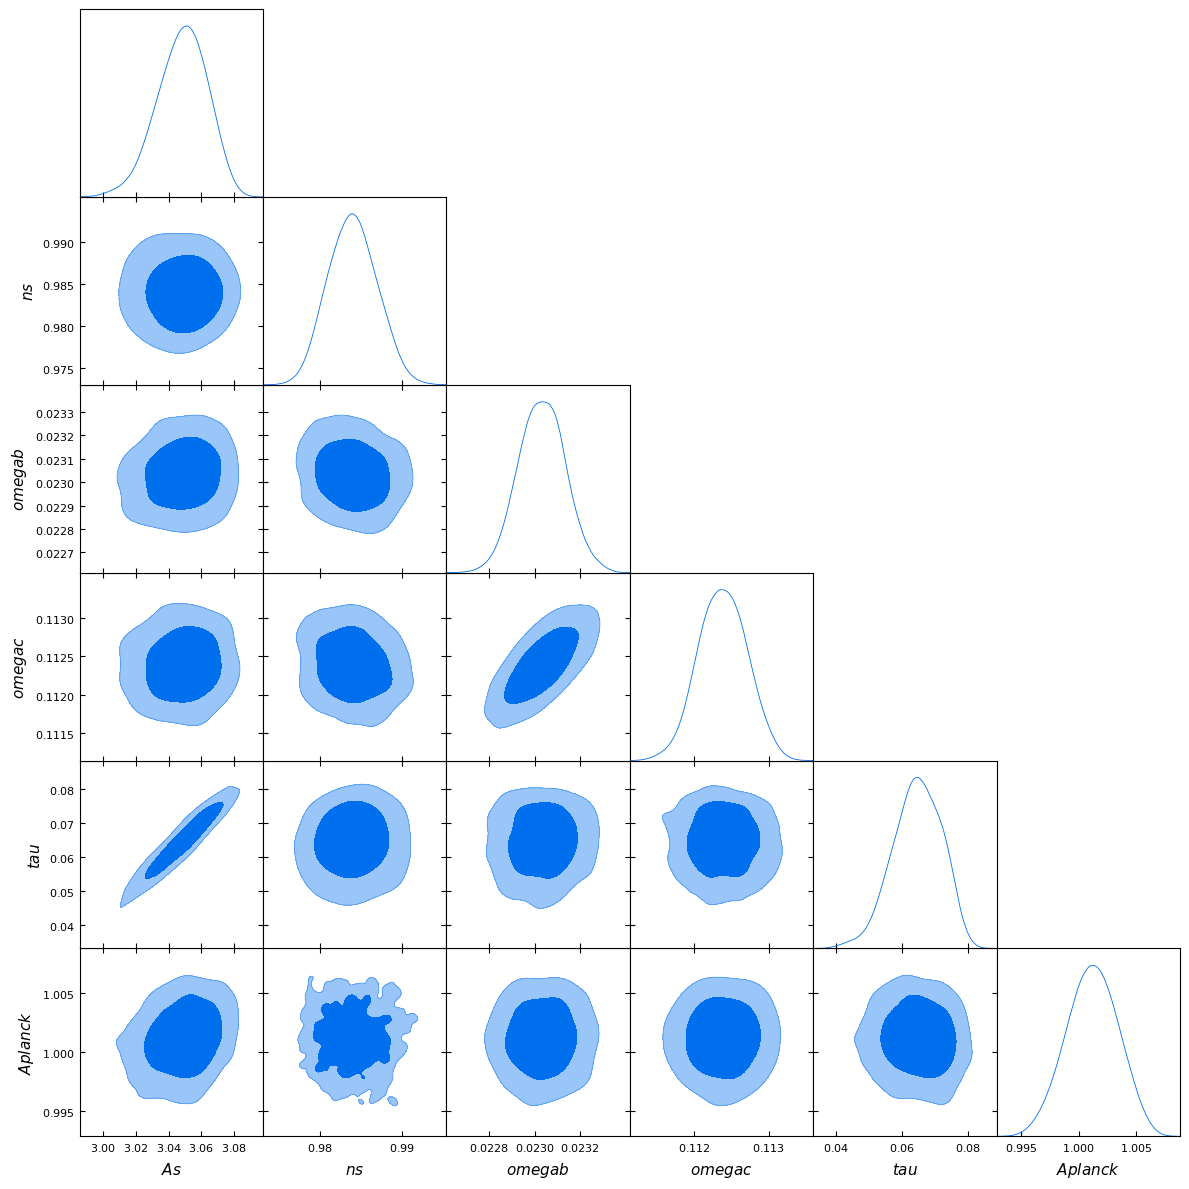

In [11]:
# ----------------------- Pseudo-BMA ----------------------- #
from getdist.plots import GetDistPlotter
import math as m

#pbmaweight = np.load("pbmaweights2.npy")
pbmaweight = np.load("pbmaweights_arviz_comp.npy")
print(pbmaweight)
pbmaweight_dict = {'fid':pbmaweight[0],'low':pbmaweight[1],'high':pbmaweight[2]}

names = ['As', 'ns','omegab','omegac','tau', 'Aplanck']
roots = ["\pocosamples_fid2_comp","\pocosamples_low2","\pocosamples_high2"] # this might not be correct
models = ["fid","low","high"]
temperature = {'fid': 1,'low': 1,'high': 1}
model_prior = {'fid': 0.3,'low': 0.3, 'high': 0.3}
parameters = {'fid':names, 'low': names, 'high': names}        #these have to match the parameter names in the .txt
burnin = [0.3, 0.3, 0.3]
chainpath = "C:/Users/zombk/Desktop/pocomc_cross_nuts/planck-lite-py/samplestxt2"

out = fmpc.runpseudobma(pbmaweight_dict,roots=roots, models=models, chainDir=chainpath, burnin=burnin,
            priors=model_prior, temperature=temperature, pars=parameters, estimator='learnt harmonic')


#CREATE AND PLOT BMA -----------------
outnewchains=out['newchains']['Reweighted']
length = np.shape(outnewchains['As'])[0]
arraybma = np.zeros(shape=(length, 6))      #change 3/4 is adding/taking away weight column

newweights = outnewchains['weight'].to_numpy() 

for i in range(length):
    arraybma[i][0] = outnewchains['As'][i]
    arraybma[i][1] = outnewchains['ns'][i]
    #arraybma[i][2] = outnewchains['H0'][i]
    arraybma[i][2] = outnewchains['omegab'][i]
    arraybma[i][3] = outnewchains['omegac'][i]
    arraybma[i][4] = outnewchains['tau'][i]
    arraybma[i][5] = outnewchains['Aplanck'][i]

newlength = 0

#print(arraybma)

if not m.isnan(arraybma[0][0]):
    #if first column ENDS with a bunch of NaN
    for i in range(length):
        if m.isnan(arraybma[i][0]):
            #print("break here")
            break
        newlength+=1
    arraybma = arraybma[:newlength]
    newweights = outnewchains['model_weights'].to_numpy() 
    newweights = newweights[:newlength]
else:
    #if first column STARTS with a bunch of NaN
    for i in range(length):
        if not m.isnan(arraybma[i][0]):
            #print("break here")
            break
        newlength+=1
    arraybma = arraybma[newlength:]
    newweights = outnewchains['model_weights'].to_numpy() 
    newweights = newweights[newlength:]

print(newweights)

mcpbmasamps = MCSamples(samples=arraybma, weights=newweights, names = names, labels=names, label="Pseudo-BMA")

g = GetDistPlotter()
    # Add the sample to the plotter
g.triangle_plot([mcpbmasamps], filled=True#, markers={'c':params[0], 'b':params[1], 'a':params[2]}
                )
# Show the plot
plt.show() 

[1.00000000e+00 6.10622664e-16 5.55111512e-17]
Computing evidence for model:  fid
Computing evidence for model:  low
Computing evidence for model:  high
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 5.55111512e-17
 5.55111512e-17 5.55111512e-17]
Removed no burn in


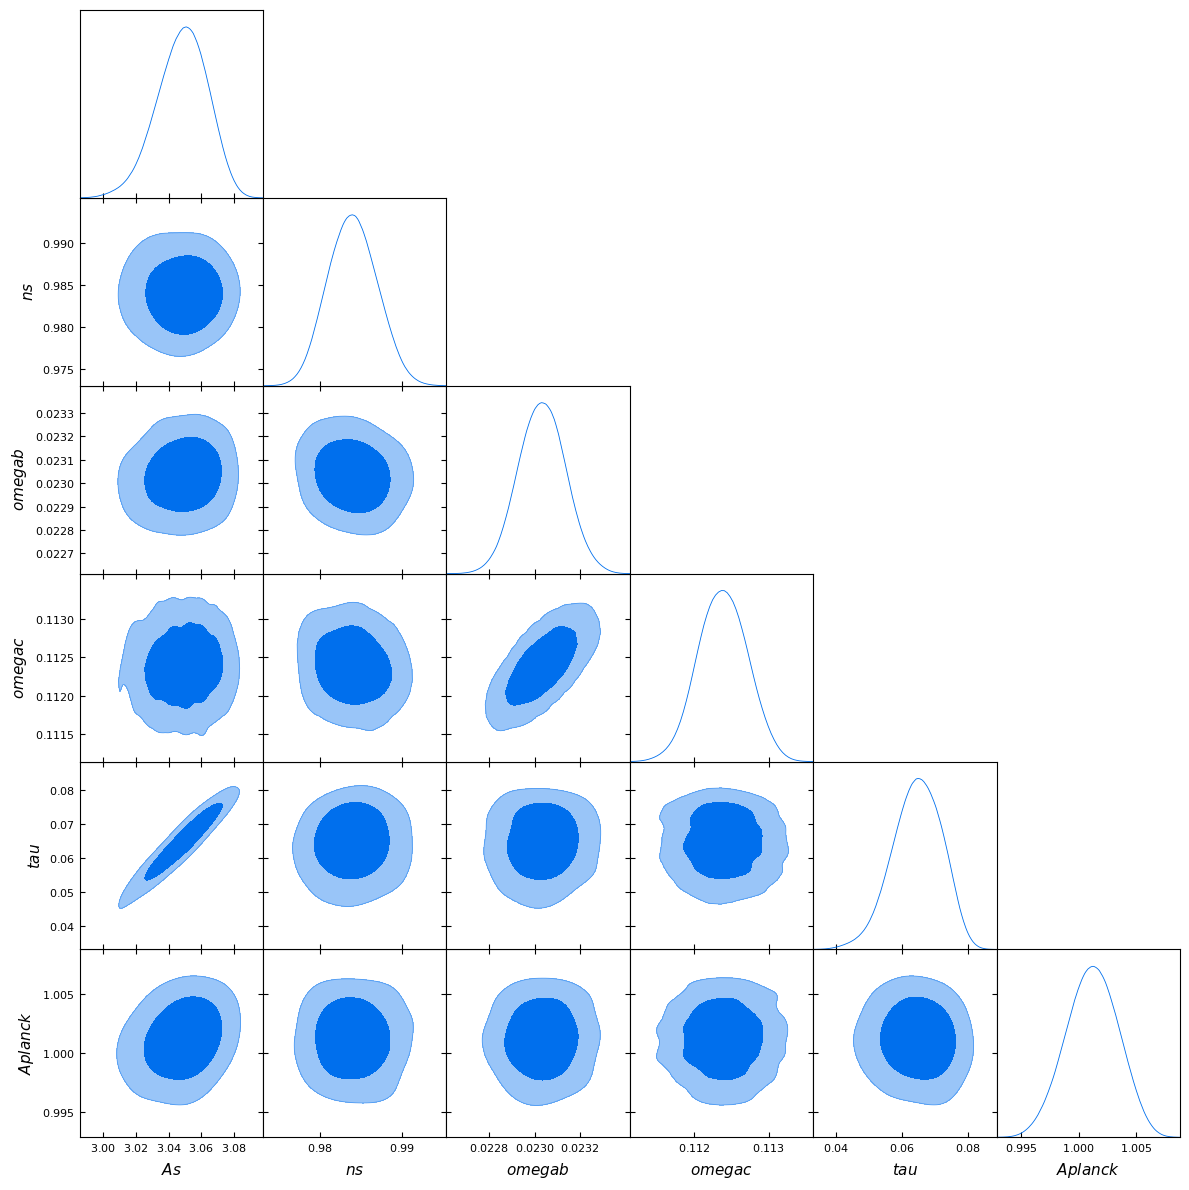

In [12]:
# ----------------------- Stacking ----------------------- #
from getdist.plots import GetDistPlotter
import math as m

#stackweight = np.load("stackweights2.npy")
stackweight = np.load("stackweights_arviz_comp.npy")
print(stackweight)
stackweight_dict = {'fid':stackweight[0],'low':stackweight[1],'high':stackweight[2]}



names = ['As', 'ns','omegab','omegac','tau', 'Aplanck']
roots = ["\pocosamples_fid2_comp","\pocosamples_low2","\pocosamples_high2"] # this might not be correct
models = ["fid","low","high"]
temperature = {'fid': 1,'low': 1,'high': 1}
model_prior = {'fid': 0.3,'low': 0.3, 'high': 0.3}
parameters = {'fid':names, 'low': names, 'high': names}        #these have to match the parameter names in the .txt
burnin = [0.3, 0.3, 0.3]
chainpath = "C:/Users/zombk/Desktop/pocomc_cross_nuts/planck-lite-py/samplestxt2"

out = fmpc.runstack(stackweight_dict,roots=roots, models=models, chainDir=chainpath, burnin=burnin,
            priors=model_prior, temperature=temperature, pars=parameters, estimator='learnt harmonic')


#CREATE AND PLOT BMA -----------------
outnewchains=out['newchains']['Reweighted']
length = np.shape(outnewchains['As'])[0]
arraybma = np.zeros(shape=(length, 6))      #change 3/4 is adding/taking away weight column

newweights = outnewchains['weight'].to_numpy() 

for i in range(length):
    arraybma[i][0] = outnewchains['As'][i]
    arraybma[i][1] = outnewchains['ns'][i]
    #arraybma[i][2] = outnewchains['H0'][i]
    arraybma[i][2] = outnewchains['omegab'][i]
    arraybma[i][3] = outnewchains['omegac'][i]
    arraybma[i][4] = outnewchains['tau'][i]
    arraybma[i][5] = outnewchains['Aplanck'][i]

newlength = 0

#print(arraybma)

if not m.isnan(arraybma[0][0]):
    #if first column ENDS with a bunch of NaN
    for i in range(length):
        if m.isnan(arraybma[i][0]):
            #print("break here")
            break
        newlength+=1
    arraybma = arraybma[:newlength]
    newweights = outnewchains['model_weights'].to_numpy() 
    newweights = newweights[:newlength]
else:
    #if first column STARTS with a bunch of NaN
    for i in range(length):
        if not m.isnan(arraybma[i][0]):
            #print("break here")
            break
        newlength+=1
    arraybma = arraybma[newlength:]
    newweights = outnewchains['model_weights'].to_numpy() 
    newweights = newweights[newlength:]

print(newweights)

mcstacksamps = MCSamples(samples=arraybma, weights=newweights, names = names, labels=names, label="Stacking")

g = GetDistPlotter()
    # Add the sample to the plotter
g.triangle_plot([mcstacksamps], filled=True#, markers={'c':params[0], 'b':params[1], 'a':params[2]}
                )
# Show the plot
plt.show() 

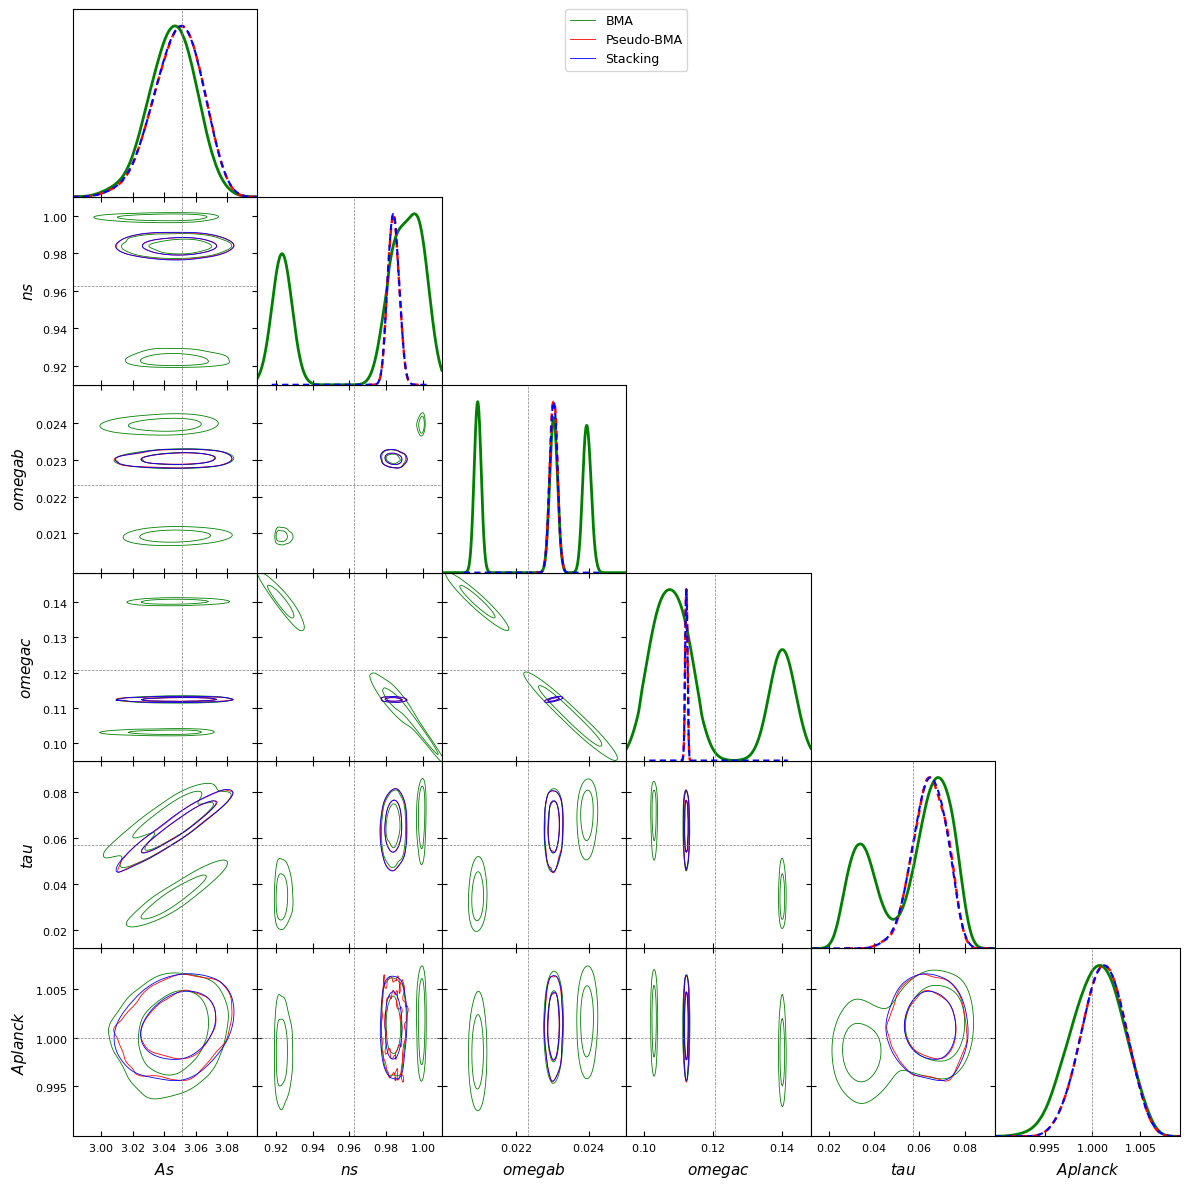

In [13]:
# ---------------- Plot ---------------- #

trueparams = {'As':3.051, 'ns':0.9626,'omegab':0.02233,'omegac':0.1207,'tau':0.057, 'Aplanck':1.00}
input_fid = np.array([3.054, 0.9626, 0.02233, 0.1207, 0.057, 1.00])


'''
# Compare Models
g = plots.get_subplot_plotter()
g.triangle_plot([gdsamples_fid, gdsamples_low,  gdsamples_high, MCbmasamples], filled=False, legend_labels=['Low H0','Fid H0','High H0','BMA'], 
            markers=trueparams, line_args=[{'color':'orange'},
                                        {'color':'red'},
                                        {'color':'blue'},
                                        {'color':'green','ls':'--','lw':1.2}], 
                            contour_args=[{'color':'orange'},
                                        {'color':'red'},
                                        {'color':'blue'},
                                        {'color':'green'}])
'''

# Compare Methods
g = plots.get_subplot_plotter()
g.triangle_plot([MCbmasamples, mcpbmasamps, mcstacksamps], filled=False, 
                legend_labels=['BMA','Pseudo-BMA','Stacking'], 
            markers=trueparams, line_args=[
                                            {'color':'green','lw':2},
                                            {'color':'red','ls':'--','lw':1.75},
                                            {'color':'blue','ls':'--','lw':1.5}], 
                                            contour_colors=['green','red','blue'])

In [ ]:
def loglike(input):
    Dl_TT, Dl_TE, Dl_EE = emu_planck_fn(input)
    return TTTEEE2018_lowTTbins.loglike(Dl_TT, Dl_TE, Dl_EE, ellmin)

def logprioremcee(theta):
    As, ns, H0, wb, wc, t, Ap = theta

    Aslow = 2.5
    Ashigh = 3.5

    nslow = 0.92
    nshigh = 1.0

    H0low = 63
    H0high = 72

    wblow = 0.01985
    wbhigh = 0.025

    wclow = 0.1
    wchigh = 0.15

    if Aslow<As<Ashigh and nslow<ns<nshigh and H0low<H0<H0high and wblow<wb<wbhigh and wclow<wc<wchigh:
        return np.log(1/((Ashigh-Aslow)*(nshigh-nslow)*(H0high-H0low)*(wbhigh-wblow)*(wchigh-wclow))) + np.log(0.5*(t-0.0506)*(t-0.0506)/0.0086/0.0086) + np.log(0.5*(Ap-1.0)*(Ap-1.0)/0.0025/0.0025)


    else:
        return -np.inf

def logpost(theta):
    like=loglike(theta)
    logp = logprioremcee(theta)
    return like + logp

flatsamples = np.load('flat_samples.npy')

def logpost2(theta):
    like=loglike(theta)
    logp = logprioremcee(theta)
    logpost = like + logp
    return -logpost, -logp

lpostlow = np.zeros(np.shape(flatsamples)[0])
lprior = np.zeros(np.shape(flatsamples)[0])
for i in range(np.shape(flatsamples)[0]):
        lpostlow[i], lprior[i] = logpost2(flatsamples[i][:])

fullshape = (np.shape(flatsamples)[0], np.shape(flatsamples)[1]+3)
fullsamples= np.zeros(fullshape)

for i in range(np.shape(flatsamples)[0]):
    for j in range(np.shape(flatsamples)[1]):
        fullsamples[i][j] = flatsamples[i][j]
        fullsamples[i][np.shape(flatsamples)[1]] = lpostlow[i]
        fullsamples[i][np.shape(flatsamples)[1]+1] = lprior[i]
        fullsamples[i][np.shape(flatsamples)[1]+2] = 1.0

names=['As', 'ns', 'H0','omegab','omegac','tau', 'Aplsnck']                    
    
gdsamples = MCSamples(samples=flatsamples, names = names, labels = ['As', 'ns', 'H_0','omegab','omegac','tau', 'Aplsnck']
                      )      

g = plots.get_subplot_plotter()
g.triangle_plot(gdsamples, filled=True#, markers={'a':params[2],'b':params[1],'c':params[0]}
                                                                                )